In [1]:
# Use black formatter
# %load_ext lab_black

import os
import numpy as np
from matplotlib import pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, accuracy_score

RANDOM_STATE = 17

In [2]:
BASE_PATH = "notebooks/CEIA-inteligencia_artificial/clase_6/data/UCI HAR Dataset"

X_train = np.loadtxt(os.path.join(BASE_PATH, "train", "X_train.txt"))
y_train = np.loadtxt(os.path.join(BASE_PATH, "train", "y_train.txt")).astype(int)
X_test = np.loadtxt(os.path.join(BASE_PATH, "test", "X_test.txt"))
y_test = np.loadtxt(os.path.join(BASE_PATH, "test", "y_test.txt")).astype(int)

print("Estructura features del dataset: {}".format(X_train.shape))
print("Estructura de las etiquetas: {}".format(y_train.shape))

Estructura features del dataset: (7352, 561)
Estructura de las etiquetas: (7352,)


In [3]:
# Cantidad única de clases
clases = np.unique(y_train)
clases

array([1, 2, 3, 4, 5, 6])

|     Label     |   Descripción  | 
| ------------- |:-------------: |
|       1       | Caminar        | 
|       2       | Subir escaleras|
|       3       | Bajar escaleras|
|       4       | Estar sentado  |
|       5       | Estar parado   |
|       6       | Recostarse     |

#### Aplicamos PCA

In [4]:
# Estandarizamos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Aplicamos PCA
pca = PCA(n_components=2, random_state=RANDOM_STATE).fit(X_train_scaled)
X_train_pca = pca.transform(X_train_scaled)

print(f"Utilizamos {pca.n_components_} de las {X_train_scaled.shape[1]} features")

Utilizamos 2 de las 561 features


#### Calsifiación

In [5]:
# Armamos máscaras para mapear las actividades a reposo (1) o movimiento (0)
# y = {1, 2, 3} => 0, y = {4, 5, 6} => 1
y_train_reduced = y_train.copy()
y_train_reduced[y_train <= 3] = 0
y_train_reduced[y_train > 3] = 1
y_train_reduced.shape

(7352,)

In [6]:
# La clase LogisticRegression de sklearn no utiliza Gradient Descent como método de optimización, por lo tanto no es necesario pasarle el parámetros como learning rate, batch size o epochs. Se pueden optar por otros métodos de optimización como SAG (Stochastic Average Gradient) u otros pero estos tampoco requieren de parámetros.
logistic_regression = LogisticRegression(fit_intercept=True)  # fit_intercept = bias
logistic_regression.fit(X_train_pca, y_train_reduced)

LogisticRegression()

In [7]:
def print_metrics(y_true, y_pred):
    metrics = {
        "Accuracy": accuracy_score,
        "Precision": precision_score,
        "Recall": recall_score,
    }
    for name, metric in metrics.items():
        result = metric(y_true, y_pred)
        print(f"{name}: {result}")


predictions = logistic_regression.predict(X_train_pca)
print_metrics(y_train_reduced, predictions)

Accuracy: 0.9979597388465724
Precision: 0.9990147783251232
Recall: 0.9972953036636342


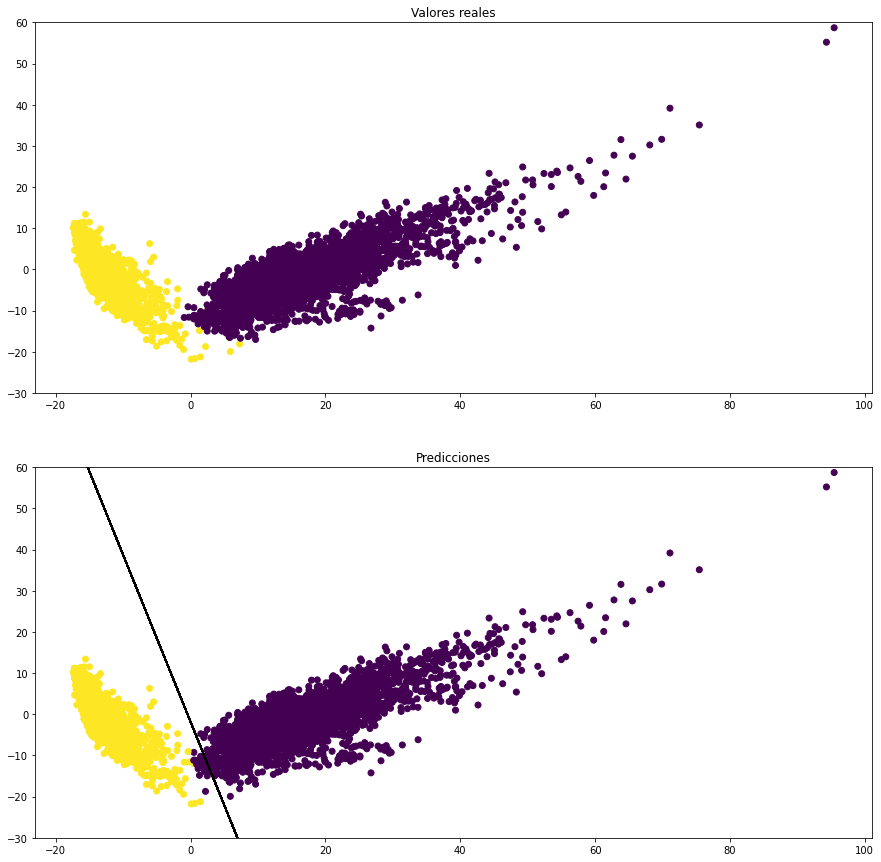

In [8]:
# Graficos

slope = -(logistic_regression.coef_[0][0] / logistic_regression.coef_[0][1])
intercept = logistic_regression.intercept_[0]

f, (ax, bx) = plt.subplots(2, 1, sharey="col", figsize=(15, 15))

ax.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train_reduced)
ax.set_title("Valores reales")
ax.set_ylim((-30, 60))

bx.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=predictions)
y_vals = intercept + (slope * X_train_pca[:, 0])
bx.plot(X_train_pca[:, 0], y_vals, c="k")
bx.set_title("Predicciones")
bx.set_ylim((-30, 60))

plt.show()

En este punto no me queda del todo claro por que la línea de decision boundary no separa correctamente todos los puntos de un color de un lado y los del otro color del otro. Es decir, se puede ver que algunos puntos violetas se encuentran del lado izquierdo de la linea. Si esta es supuestamente la frontera entre una clase y la otra, no deberían tener todos los puntos de cada lado un mismo color?

#### Test

In [9]:
X_test_scaled = scaler.fit_transform(X_test)
pca = PCA(n_components=2, random_state=RANDOM_STATE).fit(X_test_scaled)
X_test_pca = pca.transform(X_test_scaled)
X_test_pca.shape

(2947, 2)

In [10]:
y_test_reduced = y_test.copy()
y_test_reduced[y_test <= 3] = 0
y_test_reduced[y_test > 3] = 1
y_test_reduced.shape

(2947,)

In [11]:
predictions = logistic_regression.predict(X_test_pca)

result = print_metrics(y_test_reduced, predictions)

Accuracy: 0.999660671869698
Precision: 1.0
Recall: 0.9993589743589744


Me provoca cierta descofinanza el hecho de que los valores de Accuracy, Precision y Recall sean mayores que en el set de test que en el de train, no debería ser al revés?

|    Metric   |   Train   |    Test   | 
| ----------- | :-------: | :-------: |
|  Accuracy   |   0.997   |   0.999   | 
|  Precision  |   0.999   |    1.0    |
|  Recall     |   0.997   |   0.999   |


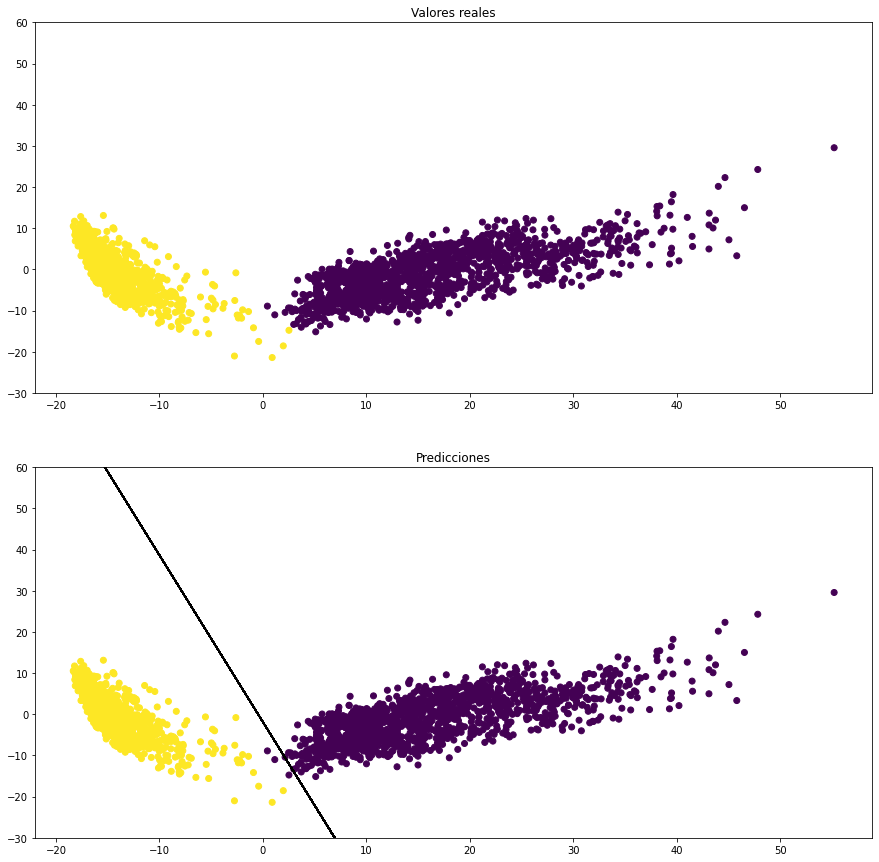

In [12]:
# Graficos

predictions = logistic_regression.predict(X_test_pca)
slope = -(logistic_regression.coef_[0][0] / logistic_regression.coef_[0][1])
intercept = logistic_regression.intercept_[0]

f, (ax, bx) = plt.subplots(2, 1, sharey="col", figsize=(15, 15))

ax.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_test_reduced)
ax.set_title("Valores reales")
ax.set_ylim((-30, 60))

bx.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=predictions)
y_vals = intercept + (slope * X_test_pca[:, 0])
bx.plot(X_test_pca[:, 0], y_vals, c="k")
bx.set_title("Predicciones")
bx.set_ylim((-30, 60))

plt.show()